In [14]:
from google.colab import drive
drive.mount('/content/drive')
import os
import sys

os.chdir('/content/drive/MyDrive/Colab_Notebooks/Analyse_Avis')
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/Analyse_Avis')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Modèle pour prédire le score ou la note que le client donnerai au service rendu sur la base de son commentaire

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.utils import shuffle
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedKFold
import zipfile
import joblib

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

#Importation du modèle BERTDISTIL (variante très léger de BERT) sur Hugging Face
from transformers import (
    DistilBertTokenizer,#Tokenizer pour DistilBert
    TFDistilBertModel,#Model DistilBert
    DataCollatorWithPadding,#Gestion du padding pour avoir les sequence de même taille
    BertTokenizer,#Model Bert
    TFBertModel#Model Bert
)

#Outils pour le suivi et la visualisation :
from tqdm.notebook import tqdm #Pour afficher barre de progression dans jupyter notebook
import itertools #Pour gérer les itérations
import multiprocessing #Pour faire de la parallélisation
import os

np.random.seed(987654321)
tf.random.set_seed(987654321)

In [16]:
# Chemin vers le fichier ZIP
zip_file_path = "archive.zip"

# Ouvrir l'archive ZIP
with zipfile.ZipFile(zip_file_path, 'r') as z:
    # Lister les fichiers dans l'archive
    print("Fichiers dans l'archive ZIP :", z.namelist())

    # Spécifier le nom du fichier CSV à charger
    csv_file_name = z.namelist()[0]  # Remplacer par le nom exact si connu

    # Charger le fichier CSV dans un DataFrame pandas
    with z.open(csv_file_name) as f:
        data = pd.read_csv(f)

# Afficher les premières lignes du DataFrame
data.head()

Fichiers dans l'archive ZIP : ['amazon_reviews.csv']


,userName,verified,itemName,description,image,brand,feature,category,price,rating,reviewTime,summary,reviewText,vote
0,Amazon Customer,True,"Toblerone Swiss Milk Chocolate Bar, Crunchy Sa...","[""Made from deliciously decadent ingredients, ...",['https://images-na.ssl-images-amazon.com/imag...,Toblerone,[],Prime_Pantry,$1.63,5.0,2018-01-01,Five Stars,super smooth and yummy with crunchy bits,0
1,Carla,True,"Prince of Peace Organic Tea, Oolong, 100 Tea Bags","['Prince of Peace Enterprises, Inc., founded i...",['https://images-na.ssl-images-amazon.com/imag...,Prince Of Peace,[],Grocery_and_Gourmet_Food,$6.40,5.0,2018-01-01,Five Stars,Perfect for kombucha,0
2,Jaclyn,True,"Pet Champion Adjustable No-Pull Harness, Colla...","[""The Pet Champion Large/ Extra Large 22-36 in...",['https://images-na.ssl-images-amazon.com/imag...,Pet Champion,"['Features Bright Pink Lemonade pattern', 'Dua...",Pet_Supplies,$7.99,5.0,2018-01-01,she has an odd shape chest and her pull over h...,Finally a harness that fits my puppy. I really...,0
3,Christinne M,False,Koh-I-Noor Progresso Woodless Colored 24-Penci...,['Koh-I-Noor Progresso Woodless Colored 24-Pen...,['https://images-na.ssl-images-amazon.com/imag...,KOH-I-NOOR,"['Rich, pigmented, solid color encased in lacq...",Arts_Crafts_and_Sewing,$14.18,5.0,2018-01-01,Loving!!,I LOVE THEM!! I bought them at Micheals our of...,0
4,Sandy,True,"Parker Urban Premium Ebony Metal Chiseled, Bal...","[""Stunning craftsmanship based on a classic st...",['https://images-na.ssl-images-amazon.com/imag...,Parker,['Ebony black with metallic highlights and a g...,Office_Products,NaN,5.0,2018-01-01,I love this pen,"I love this pen! I love the shape of it, the f...",0


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551159 entries, 0 to 551158
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   userName     551026 non-null  object 
 1   verified     551159 non-null  bool   
 2   itemName     551158 non-null  object 
 3   description  551151 non-null  object 
 4   image        551159 non-null  object 
 5   brand        547287 non-null  object 
 6   feature      551159 non-null  object 
 7   category     551159 non-null  object 
 8   price        476825 non-null  object 
 9   rating       551159 non-null  float64
 10  reviewTime   551159 non-null  object 
 11  summary      550916 non-null  object 
 12  reviewText   550731 non-null  object 
 13  vote         551159 non-null  int64  
dtypes: bool(1), float64(1), int64(1), object(11)
memory usage: 55.2+ MB


In [18]:
# Sélectionner uniquement les colonnes 'rating' et 'reviewText' avec .loc
data = data.loc[:, ['rating', 'reviewText']]

# Convertir la colonne 'rating' en type catégorie
data['rating'] = data['rating'].astype('int')

# Afficher les informations du DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551159 entries, 0 to 551158
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   rating      551159 non-null  int64 
 1   reviewText  550731 non-null  object
dtypes: int64(1), object(1)
memory usage: 8.4+ MB


## Stat Descriptive

In [19]:
data.loc[:, 'rating'].value_counts()

,count
rating,
5,379783
4,73303
3,40639
1,34021
2,23413


In [20]:
data.loc[:, 'reviewText'][10]

'Good for the price, ships quickly.'

## Gestion des NA

In [21]:
data.isnull().mean()*100

,0
rating,0.000000
reviewText,0.077655


In [22]:
data = data.dropna()
data.isnull().mean()*100

,0
rating,0.0
reviewText,0.0


## Prétraitement pour le NLP et le fine tuning

### Paramètre

In [23]:
vocab_size = 30000 #Taille max du dictionnaire pour la tokenisation ici limité aux 30 000 mots les plus fréquents dans les données d'entraînement
hide_most_frequently = 0 #ignoré les mots les plus fréquent comme "le, la , ..." qui sont peu informatif dans certaines contexte
#ici 0 nous permet de rien ignorer
review_len = 512 #fixe la longueur maximale des séquences de texte traitées ici 512 tokens, la limite standard pour BERT.

epochs = 5
batch_size = 50

fit_verbosity = 1
scale = 1

# Définir le nombre maximal de cœurs disponibles
n_cpus = os.cpu_count()

## Equilibrage des classes

In [24]:

# Trouver le plus petit effectif
min_count = data['rating'].value_counts().min()

# Rééchantillonner pour équilibrer les classes
balanced_data = data.groupby('rating').apply(lambda x: x.sample(n=min_count, random_state=42)).reset_index(drop=True)

# Vérifier les nouvelles occurrences
print("\nAprès équilibrage :")
print(balanced_data['rating'].value_counts())

# Afficher le DataFrame équilibré
print("\nDataFrame équilibré :")
balanced_data.head()
data = balanced_data
data.tail()



Après équilibrage :
rating
1    23407
2    23407
3    23407
4    23407
5    23407
Name: count, dtype: int64

DataFrame équilibré :


<ipython-input-24-f5933de7625c>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_data = data.groupby('rating').apply(lambda x: x.sample(n=min_count, random_state=42)).reset_index(drop=True)


,rating,reviewText
117030,5,Good safe protection for dogs and seats!
117031,5,As stated
117032,5,great value/price i have 4 German Shepherds an...
117033,5,"These shoes are extremely comfortable, and fit..."
117034,5,Bought this for Dragon ball Fighterz on PC. Si...


## Chargement du model BERT préentrainé et son tokenizer

In [25]:
#Fonction de chargement de modèle BERT
def load_model(distil):
  if distil:
      bert_model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")
      tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
  else:
      bert_model = TFBertModel.from_pretrained("bert-base-uncased")
      tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
  return bert_model, tokenizer

# Indiquer si vous voulez utiliser DistilBERT (True) ou BERT classique (False)
distil = True  # Remplacez par False si vous voulez utiliser BERT classique

bert_model, tokenizer = load_model(distil)
bert_model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "tf_distil_bert_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
Total params: 66362880 (253.15 MB)
Trainable params: 66362880 (253.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Tokenisation

In [26]:
#Cette fonction prend un sample (ici, une critique sous forme de texte) puis le convertit en tokens adaptés au modèle BERT.
def tokenize_sample(sample):
    return tokenizer(sample, truncation=True, max_length=review_len)

#Tokeniser un ensemble de données (dataset) en utilisant tous les cœurs CPU disponibles pour accélérer le processus.
def distributed_tokenize_dataset(dataset):
    dataset = list(dataset)
    #Pour faire des calcul en parallèle pour la tokenisation sur plusieurs coeurs
    with multiprocessing.Pool(multiprocessing.cpu_count()) as pool:
        tokenized_ds = list(tqdm(
            pool.imap(tokenize_sample, dataset),  # Tokenisation des textes bruts
            total=len(dataset)
        ))
    return tokenized_ds

X = data.loc[:, 'reviewText']
y = data.loc[:, 'rating']
y = y - 1 #Car je vais utilisé la fonction loss SparseCrossEntropie qui prend en compte -1

#Séparation en base de test et d'entrainement
text_x_train,text_x_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tokenized_x_train = distributed_tokenize_dataset(text_x_train)
tokenized_x_test = distributed_tokenize_dataset(text_x_test)

  0%|          | 0/93628 [00:00<?, ?it/s]

  0%|          | 0/23407 [00:00<?, ?it/s]

In [27]:
#S'assure que toutes les séquences ont la même longueur en les remplissant (padding) à la longueur maximale.
data_collator = DataCollatorWithPadding(tokenizer, return_tensors="tf")
#Par exemple
#data_collator(tokenized_x_train)

# transforme les données tokenisées en un format de dataset TensorFlow prêt pour l’entraînement du modèle
def make_dataset(x, y):
    collated = data_collator(x)#Faire le padding sur toutes les reviews

    """
    Chaque échantillon dans dataset est une tuple de trois éléments :
    - input_ids (séquence tokenisée),
    - attention_mask (indiquant les tokens réels vs padding) avec attention_mask un masque indiquant quelles positions correspondent aux tokens réels et lesquelles sont des tokens de padding (utile pour que le modèle ignore le padding). ,
    - y (label correspondant).
    """
    dataset = tf.data.Dataset.from_tensor_slices(
        (collated['input_ids'], collated['attention_mask'], y)
    )

    #Transformation du dataset en format adapté pour BERT qui attendent en entrée à la fois input_ids et attention_mask ensemble.
    """
    - Transforme chaque échantillon (input_ids, attention_mask, y) en ((input_ids, attention_mask), y).
    - shuffle(25000) : Mélange les données pour réduire la corrélation entre les échantillons consécutifs (valeur 25000 pour un mélange complet si c'est la taille du dataset).
    - batch(batch_size) : Regroupe les données en lots de taille batch_size (défini ailleurs comme 32).
    """
    transformed_dataset = (
        dataset.map(
            lambda x, y, z: ((x, y), z)
        ).shuffle(25000).batch(batch_size)
    )

    return transformed_dataset

train_ds = make_dataset(tokenized_x_train, y_train)
test_ds = make_dataset(tokenized_x_test, y_test)

for x, y in train_ds:
    print(x)
    print(y)
    break

(<tf.Tensor: shape=(50, 512), dtype=int32, numpy=
array([[  101,  1045,  3517, ...,     0,     0,     0],
       [  101,  2004,  2649, ...,     0,     0,     0],
       [  101, 16853,  2003, ...,     0,     0,     0],
       ...,
       [  101,  4149,  2023, ...,     0,     0,     0],
       [  101,  3398,  1010, ...,     0,     0,     0],
       [  101,  1045,  2066, ...,     0,     0,     0]], dtype=int32)>, <tf.Tensor: shape=(50, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>)
tf.Tensor(
[2 3 0 3 4 3 0 1 4 1 2 1 1 1 3 0 0 1 2 4 3 2 3 3 3 4 3 1 1 0 1 2 3 0 4 4 2
 0 2 1 1 1 4 3 4 1 3 4 4 3], shape=(50,), dtype=int64)


## Ajout de la tete de classification au modèle BERT


In [28]:
## Création de classe héritière de modèle Keras
class ClassificationModel(keras.Model):

    def __init__(self, bert_model):
        super(ClassificationModel, self).__init__()
        self.bert_model = bert_model
        """
        - pre_classifier : Une couche dense avec 768 unités et une activation relu, qui sert à transformer la sortie de BERT en une représentation adaptée pour la classification.
        - Une couche Dropout avec un taux de 0.1, utilisée pour éviter le surapprentissage en désactivant aléatoirement 10% des neurones lors de l'entraînement.
        - classifier : Une couche dense finale avec 2 unités (pour une classification binaire) et sans activation. La sortie brute de cette couche (logits) est interprétée comme les scores pour chaque classe.
        """
        self.pre_classifier = Dense(1000, activation='relu')
        self.dropout = Dropout(0.1)
        self.classifier = Dense(5)#5 pour le nombre de classe à prédire

    # Methode
    def call(self, x):
      """
      - Passage par BERT produisant une sortie last_hidden_state.
      - Extraction du token [CLS] : x[:, 0]
      - pre_classifier : La couche dense avec relu affine la représentation [CLS].
      - dropout : La couche Dropout désactive une fraction des neurones pour renforcer la robustesse du modèle.
      - classifier : La dernière couche dense produit deux logits (non normalisés), un pour chaque classe
      """
      x = self.bert_model(x)
      x = x.last_hidden_state#Pour recupérrer toute la liste d'embedding aocrrespondantt au token de chaque phrase dans l'espace latent de compréhension du modèle
      x = x[:, 0] # récupère la représentation du premier token [CLS], qui résume le sens général de la séquence (car BERT bidirectionnelle).
      x = self.pre_classifier(x)
      x = self.dropout(x)
      x = self.classifier(x)
      return x


    def get_config(self):
        config = super(ClassificationModel, self).get_config()
        # Aucun besoin de sauvegarder le modèle Hugging Face directement ici
        config.update({"num_classes": self.classifier.units})
        return config

    @classmethod
    def from_config(cls, config):
        # Vous devez recréer l'objet bert_model séparément
        raise NotImplementedError("Recréez l'objet ClassificationModel en passant un modèle Hugging Face au constructeur.")


       # Méthode de prédiction avec probabilités pour 5 classes
    def predict(self, texts):
      """
      Prédit la classe d'une liste de phrases avec probabilités.

      Args:
      texts (list): Liste de phrases à analyser.

      Returns:
      list: Liste de tuples contenant la classe prédite et la probabilité associée.
      """
      # Tokenisation des textes
      tokenized_texts = [tokenize_sample(text) for text in texts]
      collated = data_collator(tokenized_texts)

      # Convertir les données en tenseurs TensorFlow
      inputs = {
          'input_ids': tf.convert_to_tensor(collated['input_ids']),
          'attention_mask': tf.convert_to_tensor(collated['attention_mask'])
      }

      # Effectuer les prédictions
      logits = self(inputs)
      probs = tf.nn.softmax(logits, axis=-1)  # Calcule les probabilités pour chaque classe
      predictions = tf.argmax(probs, axis=-1)

      # Conversion des prédictions en étiquettes lisibles (ajustez les étiquettes à vos classes)
      class_labels = ["1", "2", "3", "4", "5"]

      # Formatage des résultats avec étiquette et probabilité
      results = [
          (class_labels[pred], float(probs[i][pred]))
          for i, pred in enumerate(predictions)
      ]

      return results



In [29]:
#Création du modèle
model = ClassificationModel(bert_model)

#Test
x = next(iter(train_ds))[0]
model(x)
model.summary()

Model: "classification_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (50, 1000)                  │         769,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (50, 1000)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (50, 5)                     │           5,005 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 774,005 (2.95 MB)

 Trainable params: 774,005 (2.95 MB)

 Non-trainable params: 0 (0.00 B)

### Entrainement

In [30]:
# Compilation du modèle
model.compile(
    optimizer=Adam(1e-5),
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=[SparseCategoricalAccuracy(name='accuracy')]
)

# Configuration du callback pour sauvegarder le modèle
checkpoint_callback = ModelCheckpoint(
    filepath="./model_checkpoint.keras",  # Ajout de l'extension .keras
    save_best_only=True,  # Sauvegarde uniquement si le modèle est meilleur
    monitor="val_loss",  # Monitore la perte de validation
    mode="min",  # Sauvegarde si la perte diminue
    save_weights_only=False,  # Sauvegarde tout le modèle (architecture + poids)
    verbose=1  # Affiche des informations lors de la sauvegarde
)

# Entraînement du modèle avec le callback
history = model.fit(
    train_ds,  # Dataset d'entraînement
    validation_data=test_ds,  # Dataset de validation
    epochs=epochs,
    batch_size=batch_size,
    verbose=fit_verbosity,
    callbacks=[checkpoint_callback]  # Ajout du callback ici
)

Epoch 1/5
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.3563 - loss: 1.4799
Epoch 1: val_loss improved from inf to 1.27654, saving model to ./model_checkpoint.keras
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 582s 304ms/step - accuracy: 0.3563 - loss: 1.4799 - val_accuracy: 0.4522 - val_loss: 1.2765
Epoch 2/5
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.4582 - loss: 1.2604
Epoch 2: val_loss improved from 1.27654 to 1.21871, saving model to ./model_checkpoint.keras
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 551s 294ms/step - accuracy: 0.4582 - loss: 1.2604 - val_accuracy: 0.4683 - val_loss: 1.2187
Epoch 3/5
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.4741 - loss: 1.2144
Epoch 3: val_loss improved from 1.21871 to 1.19776, saving model to ./model_checkpoint.keras
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 551s 294ms/step - accuracy: 0.4741 - loss: 1.2144 - val_accuracy: 0.4747 - val_loss: 1.1978
Epoch 4/5
1873/1873 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.4771 - loss: 1.1977


In [31]:
# Afficher les métriques de validation après l'entraînement
print("Validation Accuracy:", history.history['val_accuracy'])
print("Validation Loss:", history.history['val_loss'])

Validation Accuracy: [0.4521724283695221, 0.468278706073761, 0.4746870696544647, 0.4812662899494171, 0.48464134335517883]
Validation Loss: [1.2765357494354248, 1.2187119722366333, 1.197759747505188, 1.1840530633926392, 1.1761045455932617]


469/469 ━━━━━━━━━━━━━━━━━━━━ 110s 233ms/step - accuracy: 0.4894 - loss: 1.1724


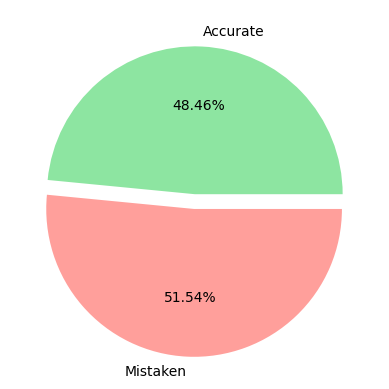

In [32]:
_, score = model.evaluate(test_ds)
colors = sns.color_palette('pastel')[2:]
accuracy_score = [score, 1 - score]
plt.pie(
    accuracy_score,
    labels=["Accurate", "Mistaken"],
    colors=colors,
    autopct=lambda val: f"{val:.2f}%",
    explode=(0.0, 0.1)
)
plt.show()

### Test sur des exemples

In [38]:
# Exemples de phrases à tester
examples = [
    "This movie was absolutely fantastic! The acting was superb and the story was captivating.",
    "I didn't like this movie at all. It was boring and way too long.",
    "The plot was interesting, but the characters lacked depth.",
    "An amazing experience!.",
    "Terrible Toys.",
    "J'aime pas trop le produit"
]

# Utilisation de la nouvelle méthode `predict`
results = model.predict(examples)

# Affichage des résultats
for text, (sentiment, probability) in zip(examples, results):
    print(f"Text: {text} | Sentiment: {sentiment} | Probability: {probability:.2f}")

Text: This movie was absolutely fantastic! The acting was superb and the story was captivating. | Sentiment: 5 | Probability: 0.91
Text: I didn't like this movie at all. It was boring and way too long. | Sentiment: 2 | Probability: 0.43
Text: The plot was interesting, but the characters lacked depth. | Sentiment: 3 | Probability: 0.47
Text: An amazing experience!. | Sentiment: 5 | Probability: 0.87
Text: Terrible Toys. | Sentiment: 1 | Probability: 0.82
Text: J'aime pas trop le produit | Sentiment: 5 | Probability: 0.39


### Sérialisation pour le déployement

In [37]:

#-------------------PAS BESOIN POUR UN DEPLOIEMENT FLASK------------------------------------

# Extraire la spécification des éléments du dataset
input_spec = train_ds.element_spec[0]

# Si `input_spec` est un objet TensorSpec, utilisez `shape`
metadata = {
    "description": "Modèle de classification entraîné avec Adam et Sparse Categorical Crossentropy.",
    "input_shape": input_spec.shape if hasattr(input_spec, 'shape') else None,  # Récupère la forme des données d'entrée
    "output_shape": (None, 5),  # Exemple pour 5 classes, ajustez selon votre cas
    "classes": ["1", "2", "3", "4", "5"]  # Exemple des classes
}

# Sauvegarder les métadonnées avec joblib
joblib.dump(metadata, "model_metadata.pkl")

print("Métadonnées sauvegardées :", metadata)

Métadonnées sauvegardées : {'description': 'Modèle de classification entraîné avec Adam et Sparse Categorical Crossentropy.', 'input_shape': None, 'output_shape': (None, 5), 'classes': ['1', '2', '3', '4', '5']}


In [36]:
# Charger le modèle en fournissant les classes personnalisées
best_model = load_model(
    "./model_checkpoint.keras",
    custom_objects={'ClassificationModel': ClassificationModel}
)

# Évaluer sur le dataset de test
test_loss, test_accuracy = best_model.evaluate(test_ds)
print(f"Perte sur les données de test : {test_loss}")
print(f"Précision sur les données de test : {test_accuracy}")

# Convertir en format SavedModel pour le déploiement
best_model.save("./saved_model", save_format="tf")

TypeError: load_model() got an unexpected keyword argument 'custom_objects'